# Pump It Up
## Data Mining the Water Table

This notebook consists of initial EDA for the DrivenData competition <a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/">Pump it Up: Data Mining the Water Table</a>.

### Features

* `amount_tsh`: total static head (amount water available to waterpoint)
* `date_recorded`: the date the row was entered
* `funder`: who funded the well
* `gps_height`: altitude of the well
* `installer`: organization that installed the well
* `longitude`: gps coordinate
* `latitude`: gps coordinate
* `wpt_name`: name of the waterpoint if there is one
* `num_private`: ?
* `basin`: geographic water basin
* `subvillage`: geographic location
* `region`: geographic location
* `region_code`: geographic location (coded)
* `district_code`: geographic_location (coded)
* `lga`: geographic location (local government area)
* `ward`: geographic location
* `population`: population around the well
* `public_meeting`: True/False
* `recorded_by`: group entering this row of data
* `scheme_management`: who operates the waterpoint
* `scheme_name`: who operates the waterpoint
* `permit`: if the waterpoint is permitted
* `construction_year`: year the waterpoint was constructed
* `extraction_type`: the kind of extraction the waterpoint uses
* `extraction_type_group`: the kind of extraction the waterpoint uses
* `extraction_type_class`: the kind of extraction the waterpoint uses
* `management`: how the waterpoint is managed
* `management_group`: how the waterpoint is managed
* `payment`: what the water costs
* `water_quality`: the quality of the water
* `quality_group`: the quality of the water
* `quantity`: the quantity of water
* `source`: the source of the water
* `source_type`: the source of the water
* `source_class`: the source of the water
* `waterpoint_type`: the kind of waterpoint
* `waterpoint_type_group`: the kind of waterpoint

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import tqdm
import folium
from collections import Counter
%matplotlib inline
pd.set_option('display.max_columns', None)

drop_cols = ['wpt_name', 'recorded_by']
columns_to_keep = ['id',
                   'date_recorded',
                   'amount_tsh', 
                   'gps_height', 
                   'latitude', 
                   'longitude', 
                   'basin',
                   'lga',
                   'population',
                   'permit',
                   'extraction_type',
                   'management',
                   'payment',
                   'water_quality',
                   'quantity',
                   'source',
                   'waterpoint_type',
                   'status',
                   'status_group']

numeric_columns = ['date_recorded', 
                   'amount_tsh', 
                   'gps_height', 
                   'population', 
                   'permit', 
                   'payment', 
                   'water_quality', 
                   'quantity', 'source', 
                   'status_group']

statuses = {'functional':1, 'functional needs repair':2, 'non functional':3}

status_decoder = {1:'functional', 2:'functional needs repair', 3:'non functional'}

def encode_quality(x):
    if x == 'soft':
        return 1
    else:
        return 0

def encode_tsh(x):
    if x > 250:
        return 2
    elif x > 0:
        return 1
    else:
        return 0
    
def encode_date_recorded(date):
    if date < dt.date(month=6, day=1, year=2011):
        return 1
    elif date < dt.date(month=1, day=1, year=2012):
        return 2
    elif date < dt.date(month=1, day=1, year=2013):
        return 3
    elif date < dt.date(month=3, day=10, year=2013):
        return 4
    elif date >= dt.date(month=3, day=10, year=2013):
        return 5
    else:
        return 0
    
def encode_quantity(quantity):
    if quantity == 'enough':
        return 2
    if quantity == 'insufficient':
        return 1
    else:
        return 0
    
def encode_payment(payment):
    if payment == 'never pay':
        return 0
    elif payment == 'pay annually':
        return 1
    elif payment == 'pay monthly':
        return 2
    elif payment == 'pay per bucket':
        return 3
    else:
        return -1
    
def encode_source(source):
    if source == 'hand dtw':
        return -3
    elif source == 'shallow well':
        return -2
    elif source == 'spring':
        return -1
    elif source == 'rainwater harvesting':
        return 1
    else:
        return 0
    
def encode_extraction_type(x):
    if x in ['nira/tanira', 'swn 80', 'india mark ii', 'india mark iii', 'afridev', 
             'other - rope pump', 'swn 81', 'other - play pump', 'walimi']:
        return 'human'

    elif x in  ['submersible', 'mono', 'ksb','cemo','climax', 'other - mkulima/shinyanga']:
        return 'power'

    elif x in ['windmill', 'gravity']:
        return 'nature'
    
    else:
        return 'unknown'

In [2]:
# simulations

y_true = pd.read_csv('training_labels.csv')
import random

y_true.status_group.value_counts() / len(y_true)

def one_simulation():
    x = random.random()
    
    if x < 0.543081:
        return 'functional'
    elif x < 0.543081 + 0.384242:
        return 'non functional'
    else:
        return 'functional needs repair'

def run_simulation(simulation_number, df):
    for i in df.index:
        df.loc[i, 'simulation_{}'.format(simulation_number)] = one_simulation()
    return df

def run_simulations(num_simulations, df):
    for i in tqdm.trange(num_simulations):
        df = run_simulation(i, y_true)
    
    for i in range(10):
        print(sum(df.status_group == df['simulation_{}'.format(i)]) / len(df))

In [3]:
def load_data():
    X = pd.read_csv('training_values.csv')
    y = pd.read_csv('training_labels.csv')
    
    # encode statuses
    y['status'] = y.status_group.apply(lambda x: statuses[x])
    
    # encode tsh
    X.amount_tsh = X.amount_tsh.apply(encode_tsh)
    
    # modify gps_height to one-hot
    X.gps_height = X.gps_height.apply(lambda x: int(x != 0))
    
    # convert date_recorded to datetime 'phase'
    X.date_recorded = pd.to_datetime(X.date_recorded, errors='coerce')
    X.date_recorded = X.date_recorded.apply(encode_date_recorded)
    
    # set known permits equal to 1, all else equal to 1
    X.permit = X.permit.apply(lambda x: 1 if x else 0)
    
    # set water quality to 1 for 'known to be good' and 0 otherwise
    X.water_quality = X.water_quality.apply(lambda x: int(x == 'soft'))
    
    # encode quantity: 2 for 'enough', 1 for 'insufficient', 0 for everything else
    X.quantity = X.quantity.apply(encode_quantity)
    
    # encode payment in terms of 'number of payments per year' (or -1 if unknown)
    X.payment = X.payment.apply(encode_payment)
    
    # encode source (negative: underground. 0: surface. positive: above ground)
    X.source = X.source.apply(encode_source)
    
    # encode extraction type: hand, powered, or nature
    X.extraction_type = X.extraction_type.apply(encode_extraction_type)
    df = pd.merge(X, y, left_on='id', right_on='id')
    return df[columns_to_keep]

load_data()

,id,date_recorded,amount_tsh,gps_height,latitude,longitude,basin,lga,population,permit,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status,status_group
0,69572,1,2,1,-9.856322,34.938093,Lake Nyasa,Ludewa,109,0,nature,vwc,1,1,2,-1,communal standpipe,1,functional
1,8776,4,0,1,-2.147466,34.698766,Lake Victoria,Serengeti,280,1,nature,wug,0,1,1,1,communal standpipe,1,functional
2,34310,4,1,1,-3.821329,37.460664,Pangani,Simanjiro,250,1,nature,vwc,3,1,2,0,communal standpipe multiple,1,functional
3,67743,4,0,1,-11.155298,38.486161,Ruvuma / Southern Coast,Nanyumbu,58,1,power,vwc,0,1,0,0,communal standpipe multiple,3,non functional
4,19728,2,0,0,-1.825359,31.130847,Lake Victoria,Karagwe,0,1,nature,other,0,1,0,1,communal standpipe,1,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,5,1,1,-3.253847,37.169807,Pangani,Hai,125,1,nature,water board,3,1,2,-1,communal standpipe,1,functional
59396,27263,1,2,1,-9.070629,35.249991,Rufiji,Njombe,56,1,nature,vwc,1,1,2,0,communal standpipe,1,functional
59397,37057,1,0,0,-8.750434,34.017087,Rufiji,Mbarali,0,0,human,vwc,2,0,2,0,hand pump,1,functional
59398,31282,1,0,0,-6.378573,35.861315,Rufiji,Chamwino,0,1,human,vwc,0,1,1,-2,hand pump,1,functional


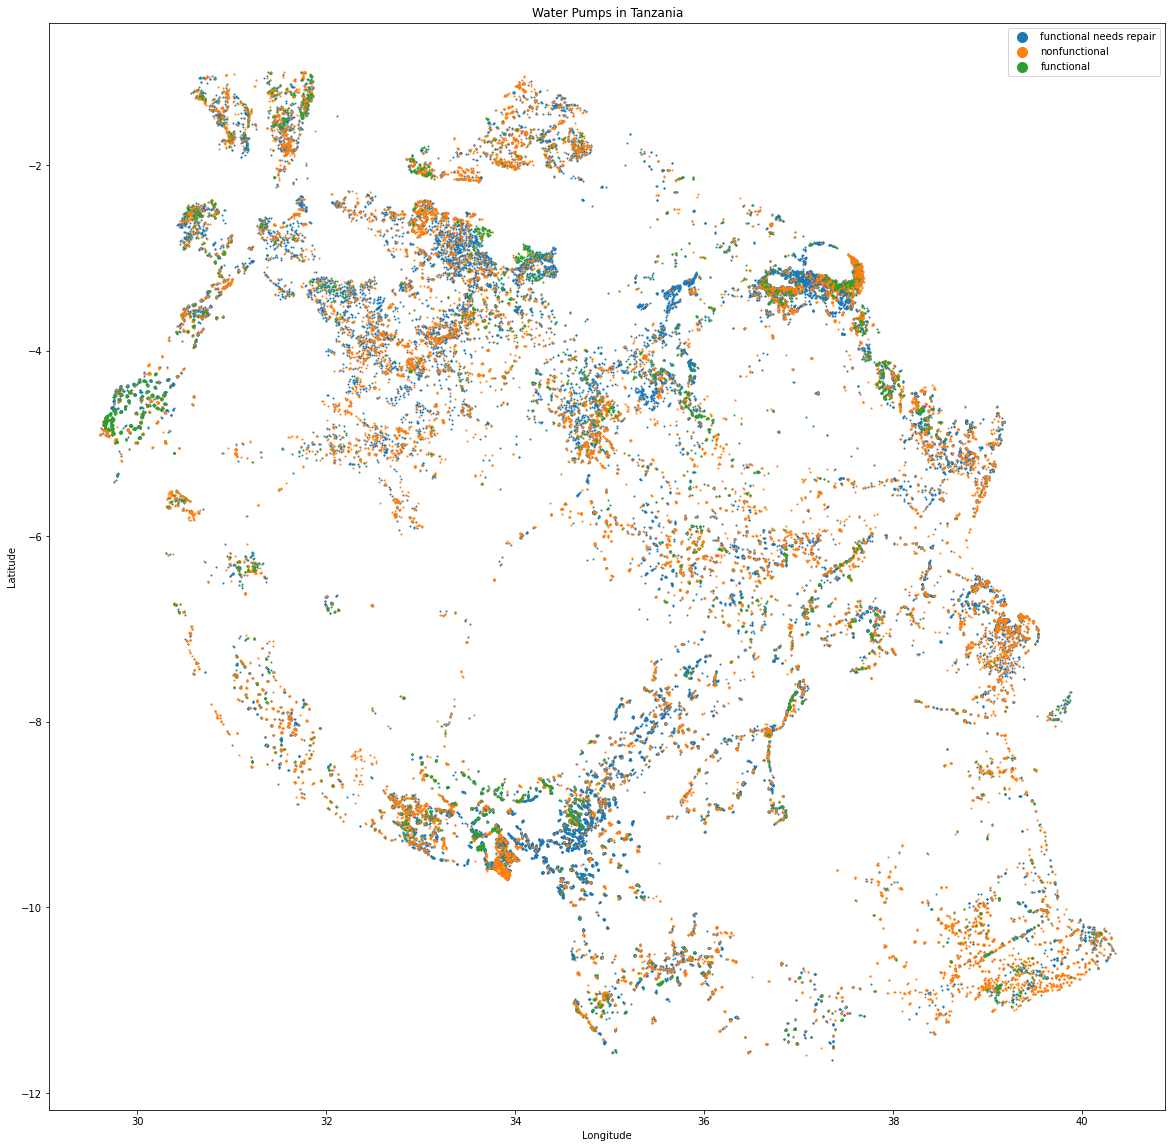

In [6]:
def plot_classes():
    df = load_data()
    df = df[df.longitude > 20]
    df_func = df[df.status_group == 'functional']
    df_nonfunc = df[df.status_group == 'non functional']
    df_nr = df[df.status_group == 'functional needs repair']
    df = df[df['longitude'] > 5]
    plt.figure(figsize=(20, 20))
    plt.scatter(df_func.longitude, df_func.latitude, s=1)
    plt.scatter(df_nonfunc.longitude, df_nonfunc.latitude, s=1)
    plt.scatter(df_nr.longitude, df_nr.latitude, s=1)
    plt.legend(['functional needs repair', 'nonfunctional', 'functional'], markerscale=10)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Water Pumps in Tanzania')
    plt.savefig('map.png')
    plt.show()
    
plot_classes()

In [3]:
def get_neighborhood(idx, lat_step=0.05, long_step=0.05, expand_factor = 0.5):
    df = load_data()
    lat = df.loc[idx, 'latitude']
    long = df.loc[idx, 'longitude']
    df = df[(df.latitude > (lat - lat_step)) &
              (df.latitude < (lat + lat_step)) &
              (df.longitude > (long - long_step)) &
              (df.longitude < (long + long_step))].drop(idx)
    if (len(df) == 0):
        #print('expanding range for index', idx)
        return get_neighborhood(idx, (1 + expand_factor) * lat_step, (1 + expand_factor) * long_step)
    return df

#get_neighborhood(17001, lat_step=0.02, long_step=0.02).status_group.value_counts()

In [6]:
def check_neighbors2(idx, lat_step=0.05, long_step=0.05):
    df = load_data()
    neighborhood = get_neighborhood(idx, 
                                    lat_step, 
                                    long_step)
    votes = []
    
    for compare_idx in neighborhood.index:
        votes += [df.loc[compare_idx, 'status_group']] * sum(df.loc[idx] == df.loc[compare_idx])
        
    return max(votes, key=votes.count)

check_neighbors2(17, 0.02, 0.02)

'non functional'

In [100]:
def check_neighbors(idx, lat_step=0.05, long_step=0.05):
    return get_neighborhood(idx, 
                           lat_step, 
                           long_step).status_group.value_counts().index[0]  

check_neighbors(17, 0.02, 0.02)

'non functional'

In [18]:
def neighbors_column(lat_step = 0.5, long_step = 0.5, sample_size=100, df=None):
    if (df is None):
        df = load_data().sample(sample_size)
    tqdm.tqdm.pandas()
    df['neighbors'] = df.progress_apply(lambda row: check_neighbors2(row.name, lat_step, long_step), axis=1)
    return df

#neighbors_column()

In [1]:
#tests = []
#for _ in range(3):
#    test = neighbors_column(lat_step=0.02, long_step=0.02, sample_size=100)
#    tests.append(sum(test.status_group == test.neighbors))

In [131]:
tests

[79, 75, 67]

In [13]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(load_data().drop(labels=['status', 'status_group'], axis=1), 
#                                                    load_data().status_group,
#                                                    test_size=0.2,
#                                                    random_state=0)

In [2]:
#y_pred = neighbors_column(lat_step=0.02, long_step=0.02, df=X_test)
#y_pred.to_csv('y_pred.csv')
#sum(y_pred.neighbors == y_train)

In [225]:
df = load_data()
df[df.lga == 'Geita']

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
53,32376,0.0,2011-08-01,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Polisi,0,Lake Victoria,Center,Mwanza,19,6,Geita,Nyang'hwale,0,True,GeoData Consultants Ltd,VWC,Nyang'hwale,True,1970-01-01,submersible,submersible,submersible,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
256,33500,0.0,2011-07-18,Hesawa,0,DWE,0.0,-2.000000e-08,Bombani,0,Lake Victoria,Ujamaa,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultants Ltd,VWC,Borehole,True,1970-01-01,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
301,70379,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Nersing College,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultants Ltd,VWC,Borehole,True,1970-01-01,afridev,afridev,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
306,59713,0.0,2011-07-30,Plan International,0,Plan Internationa,0.0,-2.000000e-08,Petro,0,Lake Victoria,Mwabasabi,Mwanza,19,6,Geita,Kasamwa,0,True,GeoData Consultants Ltd,VWC,NaN,True,1970-01-01,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
326,7900,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Hospital,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultants Ltd,VWC,Kalangalala,True,1970-01-01,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58555,50327,0.0,2011-07-28,Hesawa,0,DWE,0.0,-2.000000e-08,Boniface,0,Lake Victoria,Watoto,Mwanza,19,6,Geita,Kasamwa,0,True,GeoData Consultants Ltd,VWC,NaN,True,1970-01-01,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
58678,30723,0.0,2011-08-06,Kmcl,0,KMCL,0.0,-2.000000e-08,Bombani,0,Lake Victoria,Bugombela,Mwanza,19,6,Geita,Kakora,0,True,GeoData Consultants Ltd,VWC,Nyamtukuza,True,1970-01-01,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,lake,river/lake,surface,communal standpipe,communal standpipe,functional
58997,10595,0.0,2011-08-20,Tasaf,0,TASAF,0.0,-2.000000e-08,Bombani,0,Lake Tanganyika,Elimu,Mwanza,19,6,Geita,Kaseme,0,True,GeoData Consultants Ltd,VWC,Borehole,True,1970-01-01,india mark ii,india mark ii,handpump,vwc,user-group,pay when scheme fails,on failure,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59120,34064,0.0,2011-08-18,Hesawa,0,DWE,0.0,-2.000000e-08,Shuleni,0,Lake Tanganyika,Elimu,Mwanza,19,6,Geita,Lwamgasa,0,True,GeoData Consultants Ltd,VWC,NaN,True,1970-01-01,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [241]:
def get_geita():
    df = load_data()
    df = df[df.lga == 'Geita']
    #df = df[(df.longitude > 1)]
    return df

get_geita()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
53,32376,0.0,2011-08-01,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Polisi,0,Lake Victoria,Center,Mwanza,19,6,Geita,Nyang'hwale,0,True,GeoData Consultants Ltd,VWC,Nyang'hwale,True,1970-01-01,submersible,submersible,submersible,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
256,33500,0.0,2011-07-18,Hesawa,0,DWE,0.0,-2.000000e-08,Bombani,0,Lake Victoria,Ujamaa,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultants Ltd,VWC,Borehole,True,1970-01-01,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
301,70379,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Nersing College,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultants Ltd,VWC,Borehole,True,1970-01-01,afridev,afridev,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
306,59713,0.0,2011-07-30,Plan International,0,Plan Internationa,0.0,-2.000000e-08,Petro,0,Lake Victoria,Mwabasabi,Mwanza,19,6,Geita,Kasamwa,0,True,GeoData Consultants Ltd,VWC,NaN,True,1970-01-01,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
326,7900,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Hospital,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultants Ltd,VWC,Kalangalala,True,1970-01-01,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58555,50327,0.0,2011-07-28,Hesawa,0,DWE,0.0,-2.000000e-08,Boniface,0,Lake Victoria,Watoto,Mwanza,19,6,Geita,Kasamwa,0,True,GeoData Consultants Ltd,VWC,NaN,True,1970-01-01,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
58678,30723,0.0,2011-08-06,Kmcl,0,KMCL,0.0,-2.000000e-08,Bombani,0,Lake Victoria,Bugombela,Mwanza,19,6,Geita,Kakora,0,True,GeoData Consultants Ltd,VWC,Nyamtukuza,True,1970-01-01,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,lake,river/lake,surface,communal standpipe,communal standpipe,functional
58997,10595,0.0,2011-08-20,Tasaf,0,TASAF,0.0,-2.000000e-08,Bombani,0,Lake Tanganyika,Elimu,Mwanza,19,6,Geita,Kaseme,0,True,GeoData Consultants Ltd,VWC,Borehole,True,1970-01-01,india mark ii,india mark ii,handpump,vwc,user-group,pay when scheme fails,on failure,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59120,34064,0.0,2011-08-18,Hesawa,0,DWE,0.0,-2.000000e-08,Shuleni,0,Lake Tanganyika,Elimu,Mwanza,19,6,Geita,Lwamgasa,0,True,GeoData Consultants Ltd,VWC,NaN,True,1970-01-01,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [243]:
def get_magu():
    df = load_data()
    df = df[df.lga == 'Magu']
    df = df[(df.longitude > 1)]
    return df

get_magu()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
164,63632,0.0,2011-07-23,Hesawz,0,DWE,33.163581,-2.546459,Kwa Bujashi,0,Lake Victoria,Matela A,Mwanza,19,2,Magu,Nyanguge,0,True,GeoData Consultants Ltd,VWC,NaN,True,1970-01-01,afridev,afridev,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
521,68495,0.0,2011-08-23,Hesawa,0,DWE,33.607881,-2.679422,Kwamonica,0,Lake Victoria,Nkungulu,Mwanza,19,2,Magu,Nkungulu,0,True,GeoData Consultants Ltd,NaN,NaN,True,1970-01-01,nira/tanira,nira/tanira,handpump,vwc,user-group,pay when scheme fails,on failure,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
827,50641,0.0,2011-07-18,Hesawa,0,DWE,33.246749,-2.513834,Kwa Laurent,0,Lake Victoria,Kigangama A,Mwanza,19,2,Magu,Kitongo Sima,0,True,GeoData Consultants Ltd,VWC,NaN,True,1970-01-01,other,other,other,vwc,user-group,never pay,never pay,salty,salty,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
941,20697,0.0,2011-08-05,Government Of Tanzania,0,Government,33.551674,-2.523600,Kwa Lusafisha,0,Lake Victoria,Nyamamba,Mwanza,19,2,Magu,Lubugo,0,True,GeoData Consultants Ltd,VWC,NaN,True,1970-01-01,mono,mono,motorpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional
1102,24198,0.0,2011-08-01,Hesawa,0,DWE,33.156625,-2.478662,Kwa Ntemi,0,Lake Victoria,Chabula,Mwanza,19,2,Magu,Kongolo,0,True,GeoData Consultants Ltd,VWC,NaN,True,1970-01-01,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58597,38428,0.0,2011-08-03,Hesawa,0,DWE,33.440230,-2.643236,Magonji,0,Lake Victoria,Iibungilo,Mwanza,19,2,Magu,Nyigogo,0,True,GeoData Consultants Ltd,VWC,NaN,True,1970-01-01,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
58994,13029,0.0,2011-07-21,Nazalet Church,0,Maswi company,33.154327,-2.602927,Shuleni Malilika P/S,0,Lake Victoria,Malilika,Mwanza,19,2,Magu,Mwamanga,0,True,GeoData Consultants Ltd,VWC,NaN,True,1970-01-01,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59072,41134,0.0,2011-08-03,Hesawa,0,DWE,33.401869,-2.644608,Kwa Madirisha,0,Lake Victoria,Mwatelesha,Mwanza,19,2,Magu,Nyigogo,0,True,GeoData Consultants Ltd,VWC,NaN,True,1970-01-01,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59248,37081,0.0,2011-07-30,Hesawa,0,DWE,33.058223,-2.448200,Sese Centre,0,Lake Victoria,Sese,Mwanza,19,2,Magu,Bujashi,0,True,GeoData Consultants Ltd,VWC,NaN,True,1970-01-01,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional


In [238]:
def get_bariadi():
    df = load_data()
    df = df[df.lga == 'Bariadi']
    df = df[(df.longitude > 1)]
    return df

get_bariadi()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
383,16341,0.0,2012-10-21,Wvt,1362,WVT,34.217656,-2.974327,Mtakuja,0,Lake Victoria,Mtakuja,Shinyanga,17,1,Bariadi,Mhunze,450,True,GeoData Consultants Ltd,WUG,NaN,False,1970-01-01 00:00:00.000002008,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
764,53188,0.0,2013-02-14,Dwsp,1356,DWE,34.144579,-2.956513,Gasela,0,Lake Victoria,Matare,Shinyanga,17,1,Bariadi,Lagangabilili,500,True,GeoData Consultants Ltd,WUG,NaN,False,1970-01-01 00:00:00.000001996,swn 80,swn 80,handpump,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
795,59179,1000.0,2012-10-21,Lwi,1328,LWI,34.175690,-2.972687,Upendo,0,Lake Victoria,Kiluluma,Shinyanga,17,1,Bariadi,Mhunze,300,True,GeoData Consultants Ltd,WUG,NaN,False,1970-01-01 00:00:00.000002005,india mark ii,india mark ii,handpump,wug,user-group,pay when scheme fails,on failure,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
1291,25248,0.0,2013-01-31,Dwsp,1340,DWE,34.042961,-2.954429,Mwamabondo,0,Lake Victoria,Musoma,Shinyanga,17,1,Bariadi,Nkoma,250,False,GeoData Consultants Ltd,WUG,NaN,False,1970-01-01 00:00:00.000001998,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
1666,18326,0.0,2013-02-14,Dwsp,1354,DWE,34.176786,-2.928304,Tumaini,0,Lake Victoria,Ndolelezi,Shinyanga,17,1,Bariadi,Lagangabilili,500,True,GeoData Consultants Ltd,WUG,NaN,False,1970-01-01 00:00:00.000001997,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58303,43154,0.0,2012-10-22,Rwssp,1378,DWE,34.235404,-2.966587,Maelewano,0,Lake Victoria,Matumbi,Shinyanga,17,1,Bariadi,Mhunze,500,True,GeoData Consultants Ltd,WUG,NaN,False,1970-01-01 00:00:00.000002005,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
58464,73405,0.0,2013-02-02,Dwsp,1311,DWE,34.001878,-3.016739,Njiapanda,0,Lake Victoria,Mwambaga Magharibi,Shinyanga,17,1,Bariadi,Nkoma,1,False,GeoData Consultants Ltd,WUG,NaN,False,1970-01-01 00:00:00.000001999,other,other,other,wug,user-group,never pay,never pay,unknown,unknown,dry,dry,other,other,unknown,other,other,non functional
58762,57385,0.0,2012-10-21,Wvt,1359,WVT,34.232772,-2.936518,Twende Na Wakati,0,Lake Victoria,Mwakiliyoma,Shinyanga,17,1,Bariadi,Mhunze,360,True,GeoData Consultants Ltd,WUG,NaN,False,1970-01-01 00:00:00.000002007,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
58789,13602,500.0,2013-01-31,Wvt,1302,WVT,34.017314,-3.037176,Shule Ya Sekondari Nkoma,0,Lake Victoria,Nkoma Mjini,Shinyanga,17,1,Bariadi,Nkoma,500,True,GeoData Consultants Ltd,Parastatal,NaN,False,1970-01-01 00:00:00.000002007,gravity,gravity,gravity,parastatal,parastatal,pay annually,annually,soft,good,seasonal,seasonal,rainwater harvesting,rainwater har

In [259]:
def get_lga(lga):
    df = load_data()
    df = df[df.lga == lga]
    return df

get_lga('Geita').subvillage.unique()

array(['Center', 'Ujamaa', 'Nyanza', 'Mwabasabi', 'K/Center', 'Elimu',
       'Ngwelo', 'Beda B', 'Isengwa', 'Someli', 'Balazani', 'Mwanza',
       'Inghwero', 'Lwenge', 'Isenyi', 'Mission', 'Kakola', 'Ziwani',
       'Busengwa', 'Nduha', 'Mwendapole', 'Misungwida', "Nyang'Hulukulu",
       'Busanda', 'Nyafuba', 'Bupamba', 'Mtakuja', 'Nyawishi', 'Mwalwigi',
       'N/Center', 'Kanegele', 'Kayenze', 'Iginya', 'Bulyasungwi',
       'Lutozo', 'Mwamba', 'Kadashi', 'Mbugani', 'Mzalendo', 'Mabatini',
       'Mwadui', 'Nkalwa', 'Kitongo Store', 'Nyaruguguna Center',
       'Nyarubanga', 'Iponyobukula', 'Mduhani', 'B/Center', 'Mwamakiliga',
       'Kakora', 'Nyashima', 'Nyaweshi', "Bung'Hwangoko", 'Ujmaa A',
       'Ibisabageni', 'Mwilima', 'Ushirika', 'Nyamakale', 'Nyangholongo',
       'Kabulabunyasi', 'Nyasololo', 'Ngerela', 'Nyampa B',
       'Nyakahongola', 'Isadukilo', 'Kabiga', 'Custom', 'Imalamawazo',
       'Mimbili Center', 'Ihanamilo', 'Lukalakata', 'Iseni', 'Mkangala',
       'Bugu

In [258]:
def get_subvillage(subvillage):
    df = load_data()
    return df[df.subvillage == subvillage]

get_subvillage('Nyanza')

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
301,70379,0.0,2011-07-18,Government Of Tanzania,0,Government,0.000000,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Borehole,True,afridev,afridev,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
326,7900,0.0,2011-07-18,Government Of Tanzania,0,Government,0.000000,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Kalangalala,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
370,59310,0.0,2011-07-18,Government Of Tanzania,0,Government,0.000000,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Kalangalala,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
1600,60941,0.0,2011-07-18,Hesawa,0,DWE,0.000000,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,NaN,True,swn 80,swn 80,handpump,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
4775,25223,0.0,2011-07-15,Concern World Wide,0,DWE,31.122983,-3.085249e+00,0,Lake Tanganyika,Nyanza,Kagera,18,4,Biharamulo,Kalenge,0,True,VWC,NaN,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,improved spring,improved spring,functional
13678,4717,0.0,2011-07-18,Hesawa,0,DWE,0.000000,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Borehole,True,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
21062,37068,0.0,2011-07-18,Government Of Tanzania,0,Government,0.000000,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Kalangalala,True,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
23221,37249,0.0,2011-07-18,Aic,0,AIC,0.000000,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Borehole,True,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
24932,15828,0.0,2011-07-18,Mkurugenzi,0,K/Primary,0.000000,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,NaN,True,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
28518,68204,0.0,2011-07-18,Government Of Tanzania,0,Government,0.000000,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Kalangalala,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [261]:
def get_subvillages_by_lga(lga):
    df = load_data()
    return list(df[df.lga == lga].subvillage.unique())

get_subvillages_by_lga('Geita')

['Center',
 'Ujamaa',
 'Nyanza',
 'Mwabasabi',
 'K/Center',
 'Elimu',
 'Ngwelo',
 'Beda B',
 'Isengwa',
 'Someli',
 'Balazani',
 'Mwanza',
 'Inghwero',
 'Lwenge',
 'Isenyi',
 'Mission',
 'Kakola',
 'Ziwani',
 'Busengwa',
 'Nduha',
 'Mwendapole',
 'Misungwida',
 "Nyang'Hulukulu",
 'Busanda',
 'Nyafuba',
 'Bupamba',
 'Mtakuja',
 'Nyawishi',
 'Mwalwigi',
 'N/Center',
 'Kanegele',
 'Kayenze',
 'Iginya',
 'Bulyasungwi',
 'Lutozo',
 'Mwamba',
 'Kadashi',
 'Mbugani',
 'Mzalendo',
 'Mabatini',
 'Mwadui',
 'Nkalwa',
 'Kitongo Store',
 'Nyaruguguna Center',
 'Nyarubanga',
 'Iponyobukula',
 'Mduhani',
 'B/Center',
 'Mwamakiliga',
 'Kakora',
 'Nyashima',
 'Nyaweshi',
 "Bung'Hwangoko",
 'Ujmaa A',
 'Ibisabageni',
 'Mwilima',
 'Ushirika',
 'Nyamakale',
 'Nyangholongo',
 'Kabulabunyasi',
 'Nyasololo',
 'Ngerela',
 'Nyampa B',
 'Nyakahongola',
 'Isadukilo',
 'Kabiga',
 'Custom',
 'Imalamawazo',
 'Mimbili Center',
 'Ihanamilo',
 'Lukalakata',
 'Iseni',
 'Mkangala',
 'Bugunga',
 'Kijiweni',
 'Nyakatundu

In [262]:
def get_lga_and_subvillage(lga, subvillage):
    df = load_data()
    return df[(df.lga == lga) & (df.subvillage == subvillage)]

get_lga_and_subvillage('Geita', 'Nyanza')

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
301,70379,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Borehole,True,afridev,afridev,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
326,7900,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Kalangalala,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
370,59310,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Kalangalala,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
1600,60941,0.0,2011-07-18,Hesawa,0,DWE,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,NaN,True,swn 80,swn 80,handpump,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
13678,4717,0.0,2011-07-18,Hesawa,0,DWE,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Borehole,True,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
21062,37068,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Kalangalala,True,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
23221,37249,0.0,2011-07-18,Aic,0,AIC,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Borehole,True,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
24932,15828,0.0,2011-07-18,Mkurugenzi,0,K/Primary,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,NaN,True,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
28518,68204,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Kalangalala,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
40696,28134,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Kalangalala,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [263]:
def get_ward(ward):
    df = load_data()
    return df[df.ward == ward]

get_ward('Kalangalala')

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
256,33500,0.0,2011-07-18,Hesawa,0,DWE,0.0,-2.000000e-08,0,Lake Victoria,Ujamaa,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Borehole,True,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
301,70379,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Borehole,True,afridev,afridev,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
326,7900,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Kalangalala,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
370,59310,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Kalangalala,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
1122,47134,0.0,2011-07-19,Plan International,0,Plan Internationa,0.0,-2.000000e-08,0,Lake Victoria,Elimu,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Borehole,True,afridev,afridev,handpump,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55892,64770,0.0,2011-07-19,Plan International,0,Plan Internationa,0.0,-2.000000e-08,0,Lake Victoria,Ilungwe,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Borehole,True,afridev,afridev,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
56268,70312,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Borehole,True,afridev,afridev,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
56798,48304,0.0,2011-07-19,Plan International,0,Plan Internationa,0.0,-2.000000e-08,0,Lake Victoria,Katundu,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,NaN,True,nira/tanira,nira/tanira,handpump,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
57493,56023,0.0,2011-07-18,Government Of Tanzania,0,Government,0.0,-2.000000e-08,0,Lake Victoria,Nyanza,Mwanza,19,6,Geita,Kalangalala,0,True,VWC,Kalangalala,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,hand pump,hand pump,functional


In [269]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X = pd.read_csv('training_values.csv').drop(drop_cols, axis=1)
y = pd.read_csv('training_labels.csv')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train, y_train)

ValueError: could not convert string to float: 'Government Of Tanzania'

In [275]:
df = load_data()
df

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,6000.0,Roman,1390,Roman,34.938093,-9.856322,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,VWC,Roman,False,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,Other,NaN,True,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,25.0,Lottery Club,686,World vision,37.460664,-3.821329,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,VWC,Nyumba ya mungu pipe scheme,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,0.0,Unicef,263,UNICEF,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,VWC,NaN,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,0.0,Action In A,0,Artisan,31.130847,-1.825359,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,NaN,NaN,True,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,Germany Republi,1210,CES,37.169807,-3.253847,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,Water Board,Losaa Kia water supply,True,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,4700.0,Cefa-njombe,1212,Cefa,35.249991,-9.070629,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,VWC,Ikondo electrical water sch,True,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,0.0,NaN,0,NaN,34.017087,-8.750434,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,VWC,NaN,False,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,0.0,Malec,0,Musa,35.861315,-6.378573,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,VWC,NaN,True,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


(array([4.5708e+04, 2.5710e+03, 8.1600e+02, 0.0000e+00, 2.1000e+01,
        1.2200e+03, 5.7000e+02, 0.0000e+00, 5.5800e+02, 3.0000e+00,
        0.0000e+00, 4.2000e+01, 4.2000e+01, 3.1020e+03, 2.0000e+00,
        3.0000e+00, 1.7800e+02, 0.0000e+00, 0.0000e+00, 2.4000e+01,
        5.9000e+01, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.,  36.,  72., 108., 144., 180., 216., 252., 288., 324., 360.,
        396., 432., 468., 504., 540., 576., 612., 648., 684., 720., 756.,
        792., 828., 864., 900.]),
 <a list of 25 Patch objects>)

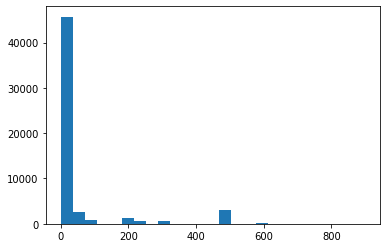

In [282]:
plt.hist(df[df.amount_tsh < 1000].amount_tsh, bins=25)

In [283]:
df[df.amount_tsh < 5]

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
1,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,Other,NaN,True,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
3,0.0,Unicef,263,UNICEF,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,VWC,NaN,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,0.0,Action In A,0,Artisan,31.130847,-1.825359,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,NaN,NaN,True,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
6,0.0,Dwsp,0,DWSP,33.362410,-3.766365,0,Internal,Ishinabulandi,Shinyanga,17,3,Shinyanga Rural,Samuye,0,True,VWC,NaN,True,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
7,0.0,Rwssp,0,DWE,32.620617,-4.226198,0,Lake Tanganyika,Nyawishi Center,Shinyanga,17,3,Kahama,Chambo,0,True,NaN,NaN,True,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,0.0,Government Of Tanzania,0,Government,33.009440,-8.520888,0,Lake Rukwa,Mbuyuni A,Mbeya,12,1,Chunya,Mbuyuni,0,True,VWC,NaN,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
59393,0.0,Private,0,Private,33.866852,-4.287410,0,Internal,Masanga,Tabora,14,2,Igunga,Igunga,0,False,Water authority,NaN,False,gravity,gravity,gravity,private operator,commercial,pay per bucket,per bucket,soft,good,insufficient,insufficient,dam,dam,surface,other,other,functional
59397,0.0,NaN,0,NaN,34.017087,-8.750434,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,VWC,NaN,False,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,0.0,Malec,0,Musa,35.861315,-6.378573,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,VWC,NaN,True,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [286]:
df = load_data()
df.lga.unique()

array(['Ludewa', 'Serengeti', 'Simanjiro', 'Nanyumbu', 'Karagwe',
       'Mkinga', 'Shinyanga Rural', 'Kahama', 'Tabora Urban', 'Mkuranga',
       'Namtumbo', 'Maswa', 'Siha', 'Meatu', 'Sumbawanga Rural', 'Njombe',
       'Ukerewe', 'Bariadi', 'Same', 'Kigoma Rural', 'Moshi Rural',
       'Lindi Rural', 'Rombo', 'Chamwino', 'Bagamoyo', 'Mafia',
       'Arusha Rural', 'Kyela', 'Kondoa', 'Kilolo', 'Kibondo', 'Makete',
       'Singida Rural', 'Masasi', 'Rungwe', 'Moshi Urban', 'Geita',
       'Mbulu', 'Bukoba Rural', 'Muheza', 'Lushoto', 'Meru', 'Iramba',
       'Kilombero', 'Mbarali', 'Kasulu', 'Bukoba Urban', 'Korogwe',
       'Bukombe', 'Morogoro Rural', 'Kishapu', 'Musoma Rural',
       'Sengerema', 'Iringa Rural', 'Muleba', 'Dodoma Urban', 'Ruangwa',
       'Hanang', 'Misenyi', 'Missungwi', 'Songea Rural', 'Tanga',
       'Tunduru', 'Hai', 'Mwanga', 'Chato', 'Biharamulo', 'Ileje',
       'Mpwapwa', 'Mvomero', 'Bunda', 'Kiteto', 'Longido', 'Urambo',
       'Mbozi', 'Sikonge', 'Ilala',

In [289]:
df[df.amount_tsh > 0].sort_values('amount_tsh')

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
15519,0.20,Government Of Tanzania,953,W.D. and I.D.,37.843340,-4.151953,0,Pangani,Kaloleni,Kilimanjaro,3,3,Same,Mwembe,112,True,VWC,Mwembe Water Supply,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
4086,0.20,Government Of Tanzania,952,Central Government,37.838427,-4.154839,0,Pangani,Kaloleni,Kilimanjaro,3,3,Same,Mwembe,32,True,VWC,Mwembe Water Supply,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,coloured,colored,insufficient,insufficient,river,river/lake,surface,communal standpipe multiple,communal standpipe,non functional
11140,0.20,Tcrs,852,TCRS,35.218314,-5.881864,0,Internal,Kanisani,Singida,13,3,Manyoni,Kintinku,450,True,NaN,NaN,False,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
49378,0.25,Ces(gmbh),685,DWE,37.357509,-3.586230,0,Pangani,Kirungu,Kilimanjaro,3,4,Moshi Rural,Arusha Chini,1,NaN,Water Board,Kirua kahe pumping water trust,True,submersible,submersible,submersible,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
3652,1.00,District Council,-20,DWE,38.977494,-5.427067,0,Pangani,Malindi,Tanga,4,5,Pangani,Pangani Mashariki,3000,False,VWC,NaN,False,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9961,138000.00,Parastatal,-7,Da,38.910446,-6.462283,0,Wami / Ruvu,Ukuni,Pwani,6,1,Bagamoyo,Dunda,587,False,Company,Bagamoyo wate,True,ksb,submersible,submersible,parastatal,parastatal,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
45067,170000.00,Owner Pingo C,127,WU,38.420467,-6.640090,0,Wami / Ruvu,Madukani,Pwani,6,1,Bagamoyo,Chalinze,150,False,WUA,Chalinze wate,True,ksb,submersible,submersible,parastatal,parastatal,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
22817,200000.00,Government Of Tanzania,98,Government,38.978067,-5.122702,0,Pangani,Pongwe Kaskazini,Tanga,4,4,Tanga,Pongwe,800,True,VWC,Pongwe Water Supply,True,submersible,submersible,submersible,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
22191,250000.00,Ded,285,WU,38.410852,-6.117538,0,Wami / Ruvu,Kipera B,Pwani,6,1,Bagamoyo,Miono,80,True,WUA,Chalinze wate,True,ksb,submersible,submersible,parastatal,parastatal,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional


(array([213.,  78.,  39.,  45.,  19.,  16.,  14.,  11.,   6.,   5.,   4.,
          5.,   1.,   4.,   4.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([   0.,   90.,  180.,  270.,  360.,  450.,  540.,  630.,  720.,
         810.,  900.,  990., 1080., 1170., 1260., 1350., 1440., 1530.,
        1620., 1710., 1800., 1890., 1980., 2070., 2160., 2250., 2340.,
        2430., 2520., 2610., 2700., 2790., 2880., 2970., 3060., 3150.,
        3240., 3330., 3420., 3510.

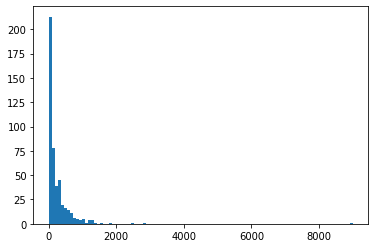

In [310]:
plt.hist(strong_pumps.population, bins=100)

In [328]:
import pandas as pd
import folium


def load_data():
    X = pd.read_csv('training_values.csv')
    y = pd.read_csv('training_labels.csv')
    df = pd.merge(X, y)
    df.date_recorded = pd.to_datetime(df.date_recorded, errors='coerce')
    df.construction_year = pd.to_datetime(df.construction_year, errors='coerce')
    return df.drop(labels=drop_cols, axis=1)

strong_pumps = load_data()
strong_pumps = strong_pumps[strong_pumps.amount_tsh > 5000]
long = (strong_pumps.longitude.max() + strong_pumps.longitude.min()) / 2
lat = (strong_pumps.latitude.max() + strong_pumps.latitude.min()) / 2
m = folium.Map(location=[lat, long], zoom_start=6)

status_color = {'functional':'green', 'functional needs repair':'orange', 'non functional':'red'}

for i in strong_pumps.index:
    location = [strong_pumps.loc[i, 'latitude'], strong_pumps.loc[i, 'longitude']]
    
    folium.Marker(location, 
                  popup='id: {},\namount_tsh: {},\npopulation: {},\nlocation: {},\nstatus: {}'
                  .format(strong_pumps.loc[i, 'id'],
                          strong_pumps.loc[i, 'amount_tsh'], 
                          strong_pumps.loc[i, 'population'],
                          str(location),
                          strong_pumps.loc[i, 'status_group']),
                  icon=folium.Icon(color=status_color.get(strong_pumps.loc[i, 'status_group'], 'gray'))
                 ).add_to(m)
    
m

In [321]:
df.status_group.unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [323]:
status_color[df.loc[13, 'status_group']]

'green'

In [73]:
idx = 18001

neighborhood = get_neighborhood(idx)
df = load_data()

long = (neighborhood.longitude.max() + neighborhood.longitude.min()) / 2
lat = (neighborhood.latitude.max() + neighborhood.latitude.min()) / 2
m = folium.Map(location=[lat, long], zoom_start=12)

status_color = {'functional':'green', 'functional needs repair':'orange', 'non functional':'red'}

for i in tqdm.tqdm(neighborhood.index):
    location = [neighborhood.loc[i, 'latitude'], neighborhood.loc[i, 'longitude']]
    
    folium.Marker(location, 
                  popup='id: {},\namount_tsh: {},\npopulation: {},\nlocation: {},\nstatus: {}\n:prediction: {}'
                  .format(neighborhood.loc[i, 'id'],
                          neighborhood.loc[i, 'amount_tsh'], 
                          neighborhood.loc[i, 'population'],
                          str(location),
                          neighborhood.loc[i, 'status_group'],
                          check_neighbors2(i)),
                  icon=folium.Icon(color=status_color.get(neighborhood.loc[i, 'status_group'], 'gray'))
                 ).add_to(m)
    
folium.Marker([df.loc[idx, 'latitude'], df.loc[idx, 'longitude']],
               popup='id: {},\namount_tsh: {},\npopulation: {},\nlocation: {},\nstatus: {},\nprediction: {}'
                  .format(df.loc[i, 'id'],
                          df.loc[i, 'amount_tsh'], 
                          df.loc[i, 'population'],
                          str(location),
                          df.loc[i, 'status_group'],
                          check_neighbors2(idx)),
              icon=folium.Icon(color='blue')).add_to(m)
    
m

KeyboardInterrupt: 

<AxesSubplot:xlabel='status_group', ylabel='count'>

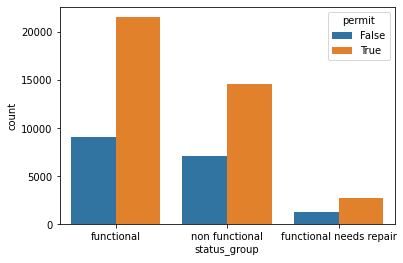

In [19]:
sns.countplot(x='status_group', hue='permit', data=load_data())

In [30]:
permits = df[df.permit == True]
no_permits = df[df.permit == False]

Text(0.5, 1.0, 'status and height')

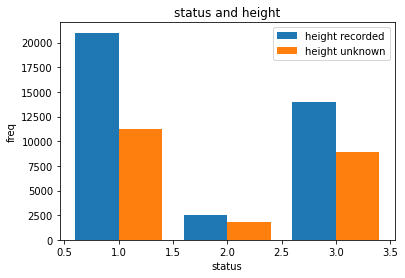

In [118]:
plt.bar(x=height.status.value_counts().index - 0.2, height=height.status.value_counts(), width=0.4)
plt.bar(x=no_height.status.value_counts().index + 0.2, height=no_height.status.value_counts(), width=0.4)
plt.xlabel('status')
plt.ylabel('freq')
plt.legend(['height recorded', 'height unknown'])
plt.title('status and height')

In [124]:
height.status_group.value_counts() / len(height)

functional                 0.560722
non functional             0.372231
functional needs repair    0.067047
Name: status_group, dtype: float64

In [123]:
no_height.status_group.value_counts() / len(no_height)

functional                 0.512948
non functional             0.404760
functional needs repair    0.082292
Name: status_group, dtype: float64

In [4]:
from sklearn.neighbors import KNeighborsClassifier
df = load_data()
clf = KNeighborsClassifier()
clf.fit()

In [5]:
load_data()

,id,date_recorded,amount_tsh,gps_height,latitude,longitude,basin,lga,population,permit,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status,status_group
0,69572,1,2,1,-9.856322,34.938093,Lake Nyasa,Ludewa,109,0,nature,vwc,1,1,2,-1,communal standpipe,1,functional
1,8776,4,0,1,-2.147466,34.698766,Lake Victoria,Serengeti,280,1,nature,wug,0,1,1,1,communal standpipe,1,functional
2,34310,4,1,1,-3.821329,37.460664,Pangani,Simanjiro,250,1,nature,vwc,3,1,2,0,communal standpipe multiple,1,functional
3,67743,4,0,1,-11.155298,38.486161,Ruvuma / Southern Coast,Nanyumbu,58,1,power,vwc,0,1,0,0,communal standpipe multiple,3,non functional
4,19728,2,0,0,-1.825359,31.130847,Lake Victoria,Karagwe,0,1,nature,other,0,1,0,1,communal standpipe,1,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,5,1,1,-3.253847,37.169807,Pangani,Hai,125,1,nature,water board,3,1,2,-1,communal standpipe,1,functional
59396,27263,1,2,1,-9.070629,35.249991,Rufiji,Njombe,56,1,nature,vwc,1,1,2,0,communal standpipe,1,functional
59397,37057,1,0,0,-8.750434,34.017087,Rufiji,Mbarali,0,0,human,vwc,2,0,2,0,hand pump,1,functional
59398,31282,1,0,0,-6.378573,35.861315,Rufiji,Chamwino,0,1,human,vwc,0,1,1,-2,hand pump,1,functional
